In [20]:
## Importing libraries
import numpy as np
import os
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import cv2
from cv2 import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K
import tensorflow as tf

In [21]:
## Setting random seed to produce reproducibility
import random as rn
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [22]:
### Libraries for model building
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

## GENERATOR FUNCTION

In [39]:
### Building a class Gen

class Gen:
    ## Inititalizing some variables
    base_folder = "./"
    train_doc = np.random.permutation(open(base_folder+"train.csv").readlines())
    val_doc = np.random.permutation(open(base_folder+"val.csv").readlines())
    train_path = base_folder+"train"
    val_path = base_folder+"val"
    num_training_sequences = len(train_doc)
    num_validation_sequences = len(val_doc)


    ## Building a method for image attributes
    def image_attributes(self,image_width=120,image_height=120,image_frames=30):
        self.image_width = image_width
        self.image_height = image_height
        self.num_classes = 5
        self.num_channels = 3
        self.image_frames = image_frames

    ### Initializing the method for getting 30 image out of each video files and then resizing and normalizing it
    def generator(self,batch_size,source_path=train_path, folder_list=train_doc):
        self.batch_size=batch_size
        print( 'Source path = ', source_path, '; batch size =', batch_size)
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        remainder_files = len(folder_list)%batch_size
        want_to_continue = True
        while want_to_continue:
            for batch in range(num_batches):
                print("This is batch:",batch)
                batch_data = np.zeros((batch_size,self.image_frames,self.image_width,self.image_height,3)) 
                batch_labels = np.zeros((batch_size,5))
                for folder in range(batch_size):
                    imgs = os.listdir(source_path+'\\'+ t[folder + (batch*batch_size)].split(';')[0])
                    for idx,item in enumerate(range(self.image_frames)):
                        image = imread(source_path+'\\'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        resized_img = resize(image,(self.image_width,self.image_height))
                        # batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255.0
                        # batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255.0
                        # batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255.0
                        batch_data[folder,idx,:,:,0] = (resized_img[:,:,0]-np.mean(resized_img[:,:,0]))/np.std(resized_img[:,:,0])
                        batch_data[folder,idx,:,:,1] = (resized_img[:,:,1]-np.mean(resized_img[:,:,1]))/np.std(resized_img[:,:,1])
                        batch_data[folder,idx,:,:,2] = (resized_img[:,:,2]-np.mean(resized_img[:,:,2]))/np.std(resized_img[:,:,2])

                        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1  
                yield batch_data, batch_labels

            if remainder_files!=0:
                for batch in range(num_batches,num_batches+1):
                    print("This is batch:",num_batches)
                    batch_data = np.zeros((remainder_files,self.image_frames,self.image_width,self.image_height,3)) 
                    batch_labels = np.zeros((remainder_files,5))
                    for folder in range(remainder_files):
                        imgs = os.listdir(source_path+'\\'+ t[folder + (num_batches*batch_size)].split(';')[0])
                        for idx,item in enumerate(range(self.image_frames)):
                            image = imread(source_path+'\\'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'\\'+imgs[item]).astype(np.float32)
                            resized_img = resize(image,(self.image_width,self.image_height))
                            batch_data[folder,idx,:,:,0] = (resized_img[:,:,0]-np.mean(resized_img[:,:,0]))/np.std(resized_img[:,:,0])
                            batch_data[folder,idx,:,:,1] = (resized_img[:,:,1]-np.mean(resized_img[:,:,1]))/np.std(resized_img[:,:,1])
                            batch_data[folder,idx,:,:,2] = (resized_img[:,:,2]-np.mean(resized_img[:,:,2]))/np.std(resized_img[:,:,2])

                            batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1   
                yield batch_data, batch_labels

In [40]:
obj = Gen()
obj.image_attributes()

In [41]:
train_generator = obj.generator(batch_size=32,source_path=obj.train_path,folder_list=obj.train_doc)
val_generator = obj.generator(batch_size=32,source_path=obj.val_path,folder_list=obj.val_doc)

Source path =  ./train ; batch size = 32
This is batch: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

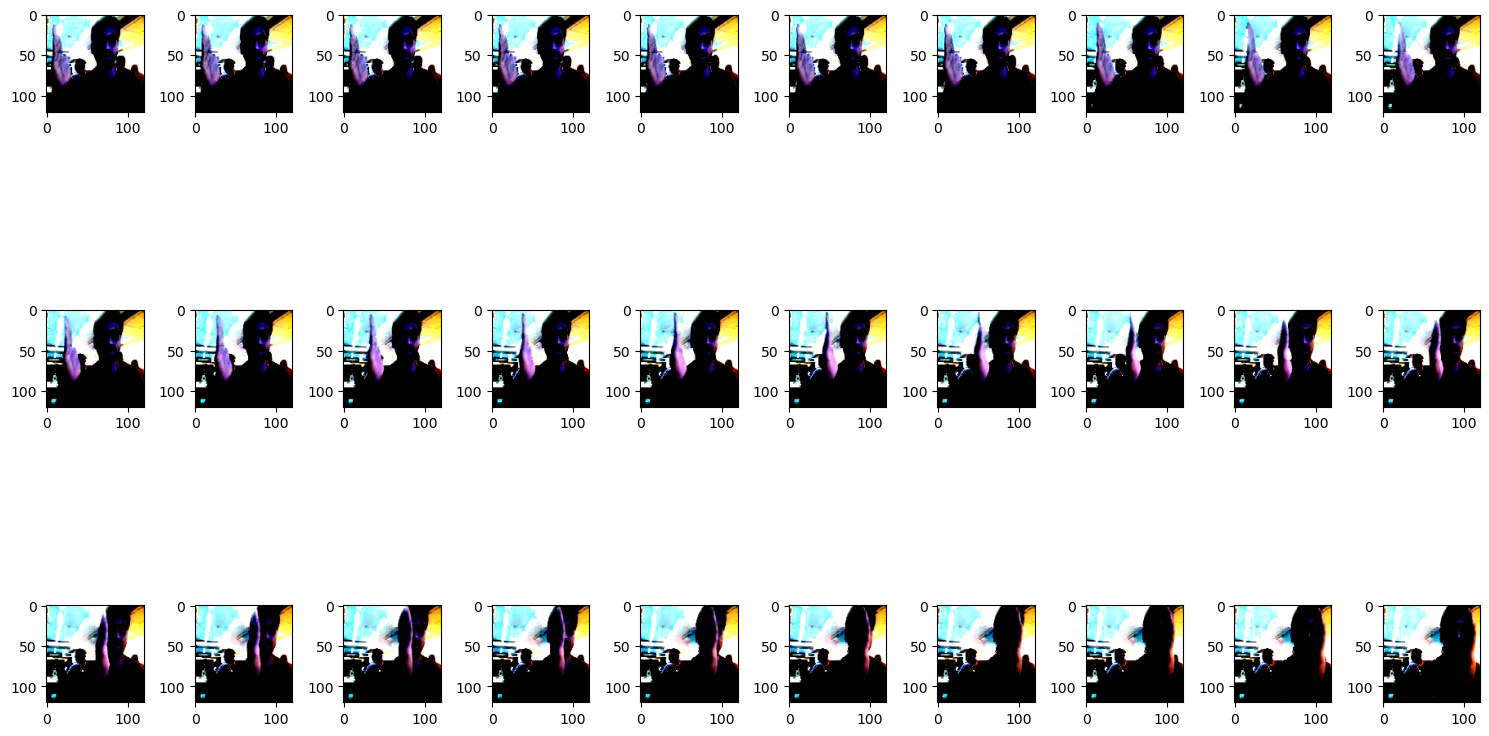

In [42]:
images,_ = next(obj.generator(batch_size=32,source_path=obj.train_path,folder_list=obj.train_doc))
fig,axes = plt.subplots(3,10,figsize=(15,10))
# Flatten the axes array to make it easier to iterate
axes = axes.flatten()
# Assuming img1 contains your images
for ax,img in zip(axes,images[0]): # Display the image on the current subplot
    ax.imshow(img)
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()



In [43]:
curr_dt_time = datetime.datetime.now()
train_path = r'C:\Users\Prince\Desktop\Upgrad\Gesture_Recognition\Project_data\train'
val_path = r'C:\Users\Prince\Desktop\Upgrad\Gesture_Recognition\Project_data\val'
num_train_sequences = len(obj.train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(obj.val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 2 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 2


### MODEL

In [44]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

input_shape = (obj.image_frames,obj.image_width,obj.image_height,3)

In [45]:
batch_size=32
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### EXPERIMENT-1
#### CONV3D ARCHITECTURE

#### 1.1 ABLATION EXPERIMENT

In [48]:
model =Sequential()
model.add(Conv3D(16,kernel_size=3,activation='relu',input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(32, kernel_size=3,activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [47]:
optimiser = optimizers.Adam(learning_rate=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_2 (Conv3D)               │ (None, 28, 118, 118,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 14, 59, 59, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 12, 57, 57, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 6, 28, 28, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,283,525 (73.56 MB)

 Trainable params: 19,283,525 (73.56 MB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
model.fit(train_generator, 
          steps_per_epoch=steps_per_epoch, 
          epochs=num_epochs, verbose=1,
          validation_data=val_generator, 
          validation_steps=validation_steps, 
          class_weight=None, initial_epoch=0)

Source path =  ./train ; batch size = 32
This is batch: 0
Epoch 1/2
This is batch: 1
 1/21 ━━━━━━━━━━━━━━━━━━━━ 2:48 8s/step - categorical_accuracy: 0.1562 - loss: 1.7751This is batch: 2
 2/21 ━━━━━━━━━━━━━━━━━━━━ 4:08 13s/step - categorical_accuracy: 0.1719 - loss: 268.0182This is batch: 3
 3/21 ━━━━━━━━━━━━━━━━━━━━ 3:56 13s/step - categorical_accuracy: 0.1736 - loss: 314.0126This is batch: 4
 4/21 ━━━━━━━━━━━━━━━━━━━━ 3:44 13s/step - categorical_accuracy: 0.1732 - loss: 311.7357This is batch: 5
 5/21 ━━━━━━━━━━━━━━━━━━━━ 3:27 13s/step - categorical_accuracy: 0.1748 - loss: 298.2378This is batch: 6
 6/21 ━━━━━━━━━━━━━━━━━━━━ 3:10 13s/step - categorical_accuracy: 0.1734 - loss: 282.4992This is batch: 7
 7/21 ━━━━━━━━━━━━━━━━━━━━ 2:56 13s/step - categorical_accuracy: 0.1729 - loss: 267.1309This is batch: 8
 8/21 ━━━━━━━━━━━━━━━━━━━━ 2:42 13s/step - categorical_accuracy: 0.1728 - loss: 252.8967This is batch: 9
 9/21 ━━━━━━━━━━━━━━━━━━━━ 2:31 13s/step - categorical_accuracy: 0.1744 - loss